In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset
- Predict housing price based on size, num of bedrooms, num of floors, age of home

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           | 

In [2]:
def load_data(f_path):
    data = np.loadtxt(f_path, delimiter=',', skiprows=1)
    X = data[:,:4]
    y = data[:,4]
    return X, y

In [3]:
X_train, y_train = load_data('datasets/houses.txt')
print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (99, 4)
y_train.shape = (99,)


#### Analysis

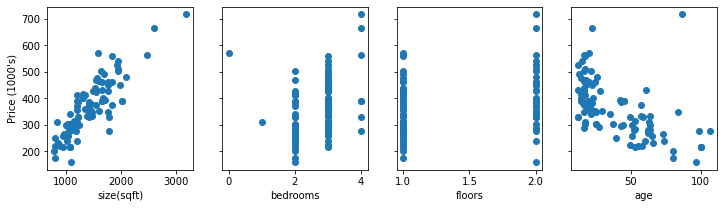

In [4]:
X_features = ['size(sqft)', 'bedrooms', 'floors', 'age']

fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

# We can see that
#     size and house age have strong influence on house price
#     num of bedrooms and num of floors have weak influence

#### Feature scaling - Normalization

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j}$$ 

- In which
    - $(i)$: data point i-th
    - $j$: feature j-th

$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2 
\end{align}
$$

In [5]:
from sklearn.preprocessing import StandardScaler
z_norm_scaler = StandardScaler()

In [6]:
X_train = z_norm_scaler.fit_transform(X_train)

# 2. Gradient descent from scratch

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [8]:
def criterion(y_hat, y):
    '''
    MSE cost
    '''
    return 0.5 * torch.mean(torch.pow(y_hat - y, 2))

class LR_GradDescent():
    def __init__(self, n):
        """
        w (torch tensor (n,))  : model parameters  
        b (torch scalar)       : model parameter
        """
        self.w = torch.rand((n), requires_grad=True, dtype=torch.float).cpu()
        self.b = torch.rand((1), requires_grad=True, dtype=torch.float).cpu()

    def __forward(self, X):
        """
        Args:
            X (torch tensor (m,n)): Data, m examples with n features
        Returns:
            y (torch tensor (m))
        """
        return X @ self.w + self.b

    def fit(self, X, y,
        batch_size=16, alpha=1e-2, num_iters=1000):

        # Dataset
        dset = TensorDataset(
            torch.Tensor(X),
            torch.Tensor(y))

        # Dataloader
        dloader = DataLoader(
            dataset=dset,
            batch_size=batch_size)

        J_hist = []
        for i in range(num_iters):
            cost = 0
            for b, batch in enumerate(dloader):
                Xb, yb = batch
                # Reset grad = 0
                if self.w.grad is not None: 
                    self.w.grad.data.zero_()
                    self.b.grad.data.zero_()
                
                # Forward   
                yb_hat = self.__forward(Xb)

                # train loss
                cost_b = criterion(yb_hat, yb)
                cost += cost_b.item()

                # Back Propagation
                cost_b.backward()
                self.w.data -= alpha * self.w.grad.data
                self.b.data -= alpha * self.b.grad.data

            # Log
            J_hist.append(cost)
            if i % 100 == 0 or i == num_iters-1:
                print(f"Iteration [{i}] : Cost = {cost:.3f}")

        return J_hist

    def eval(self, X):
        with torch.no_grad():
            y_hat = self.__forward(X) 
        return y_hat

In [9]:
lr = LR_GradDescent(n=X_train.shape[1])

J_hist = lr.fit(X_train, y_train,
    batch_size=16, alpha=5e-2, num_iters=1000)

Iteration [0] : Cost = 370531.637
Iteration [100] : Cost = 1455.446
Iteration [200] : Cost = 1455.446
Iteration [300] : Cost = 1455.446
Iteration [400] : Cost = 1455.446
Iteration [500] : Cost = 1455.446
Iteration [600] : Cost = 1455.446
Iteration [700] : Cost = 1455.446
Iteration [800] : Cost = 1455.446
Iteration [900] : Cost = 1455.446
Iteration [999] : Cost = 1455.446


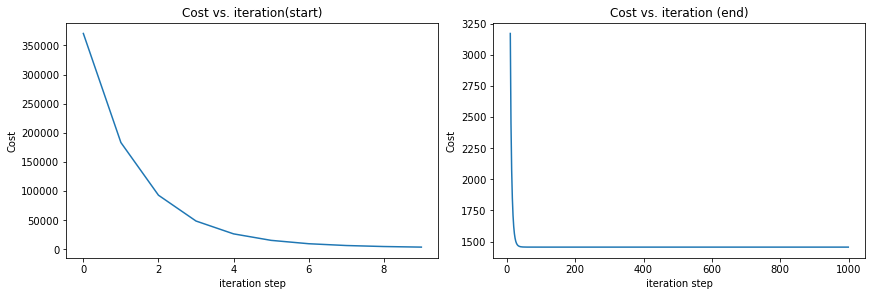

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 3. Inference

#### Inference

In [11]:
np.random.seed(3)
for x in range(3):
    i = np.random.randint(0, X_train.shape[0])
    y_hat = lr.eval(torch.tensor(X_train[i], dtype=torch.float))
    print(f'y[{i}] = {y_train[i]}, y_hat[{i}] = {y_hat}')

y[24] = 304.0, y_hat[24] = tensor([295.2332])
y[3] = 540.0, y_hat[3] = tensor([489.6449])
y[56] = 350.0, y_hat[56] = tensor([335.5042])


#### R2 Score

In [12]:
from sklearn.metrics import r2_score

y_hat = lr.eval(torch.tensor(X_train, dtype=torch.float))
r2 = r2_score(
    y_true=y_train,
    y_pred=y_hat)
print(f'R2 = {r2:.3f}')

R2 = 0.959
